# U-Net model
By Daniel Sánchez

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from pathlib import Path

import nrrd
from keras_preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from tensorflow.keras import backend as K


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
SEED = 69
BATCH_SIZE_TRAIN = 5
BATCH_SIZE_TEST = 5

IMAGE_HEIGHT = 576
IMAGE_WIDTH = 576
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = dir + './dataset/Preprocessed/'

data_dir_train = os.path.join(data_dir,'train')
data_dir_train_image = os.path.join(data_dir_train, 'img')
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir,'test')
data_dir_test_image = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 100
NUM_TEST = 54

NUM_OF_EPOCHS = 1200

In [5]:
# By Dennis Madsen
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    msk_datagen = ImageDataGenerator(**data_gen_args)

    img_generator = img_datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = msk_datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, msk_generator)

In [6]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_train(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 8800 images belonging to 1 classes.
Found 8800 images belonging to 1 classes.
Found 4752 images belonging to 1 classes.
Found 4752 images belonging to 1 classes.


In [7]:
# By Dennis Madsen
def display(display_list):

    plt.figure(figsize=(15,10))

    title = ['Input', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    
    plt.show()

In [8]:
# By Dennis Madsen
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image, mask = next(datagen)
        display([image[0], mask[0]])

In [9]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

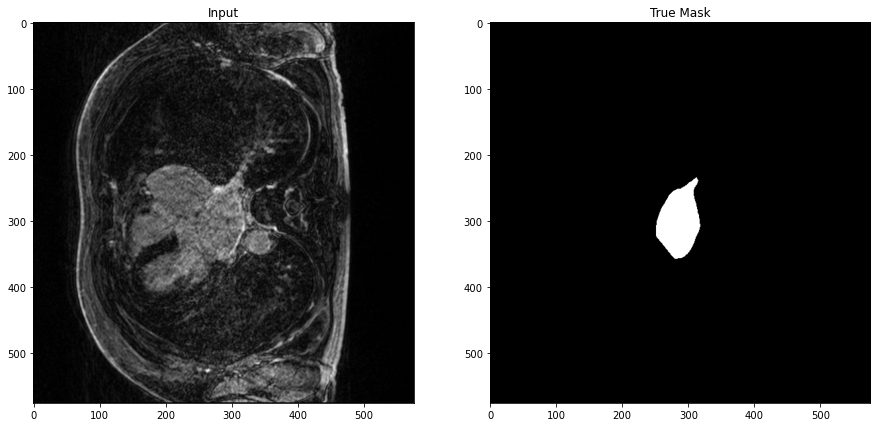

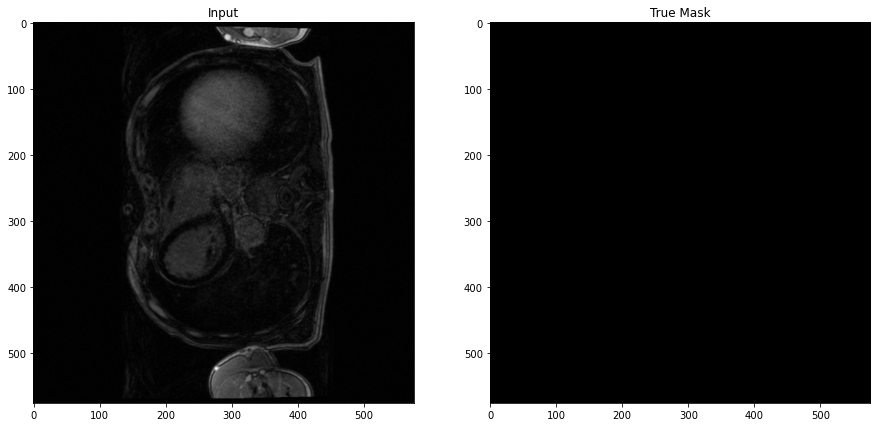

In [11]:
show_dataset(train_generator, 2)

In [12]:
def unet(initial_features=32, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    
    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    c1 = Conv2D(initial_features * 1, **convpars)(inputs)
    c1 = Conv2D(initial_features * 1, **convpars)(c1)
    p1 = MaxPool2D(pooling_size)(c1)
    
    c2 = Conv2D(initial_features * 2, **convpars)(p1)
    c2 = Conv2D(initial_features * 2, **convpars)(c2)
    p2 = MaxPool2D(pooling_size)(c2)
    
    c3 = Conv2D(initial_features * 4, **convpars)(p2)
    c3 = Conv2D(initial_features * 4, **convpars)(c3)
    p3 = MaxPool2D(pooling_size)(c3)
    
    c4 = Conv2D(initial_features * 8, **convpars)(p3)
    c4 = Conv2D(initial_features * 8, **convpars)(c4)
    p4 = MaxPool2D(pooling_size)(c4)
    
    # middle step
    c5 = Conv2D(initial_features * 16, **convpars)(p4)
    c5 = Conv2D(initial_features * 16, **convpars)(c5)
    
    # upstream
    u6 = Conv2DTranspose(initial_features * 8, strides=pooling_size, **convpars)(c5)
    m6 = concatenate([u6, c4])
    c6 = Conv2D(initial_features * 8, **convpars)(m6)
    c6 = Conv2D(initial_features * 8, **convpars)(c6)
    
    u7 = Conv2DTranspose(initial_features * 4, strides=pooling_size, **convpars)(c6)
    m7 = concatenate([u7, c3])
    c7 = Conv2D(initial_features * 4, **convpars)(m7)
    c7 = Conv2D(initial_features * 4, **convpars)(c7)
    
    u8 = Conv2DTranspose(initial_features * 2, strides=pooling_size, **convpars)(c7)
    m8 = concatenate([u8, c2])
    c8 = Conv2D(initial_features * 2, **convpars)(m8)
    c8 = Conv2D(initial_features * 2, **convpars)(c8)
    
    u9 = Conv2DTranspose(initial_features * 1, strides=pooling_size, **convpars)(c8)
    m9 = concatenate([u9, c1])
    c9 = Conv2D(initial_features * 1, **convpars)(m9)
    c9 = Conv2D(initial_features * 1, **convpars)(c9)
    
    output = Conv2D(out_channels, kernel_size=1, activation='sigmoid', padding='same')(c9)
    
    return Model(inputs=[inputs], outputs=[output], name=f'UNet-L5-F32')
    

In [13]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef])

In [14]:
model.summary()

Model: "UNet-L5-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 576, 576, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 576, 576, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 576, 576, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 288, 288, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [15]:
model.fit(train_generator, 
          steps_per_epoch=EPOCH_STEP_TRAIN, 
          validation_data=test_generator, 
          validation_steps=EPOCH_STEP_TEST,
          epochs=NUM_OF_EPOCHS)

Epoch 1/1200
20/20 [==============================] - 95s 774ms/step - loss: 0.3096 - accuracy: 0.9591 - dice_coef: 0.0058 - val_loss: 0.0648 - val_accuracy: 0.9923 - val_dice_coef: 7.0549e-04
Epoch 2/1200
20/20 [==============================] - 15s 756ms/step - loss: 0.0400 - accuracy: 0.9930 - dice_coef: 0.0150 - val_loss: 0.0398 - val_accuracy: 0.9929 - val_dice_coef: 0.0222
Epoch 3/1200
20/20 [==============================] - 15s 756ms/step - loss: 0.0374 - accuracy: 0.9921 - dice_coef: 0.0425 - val_loss: 0.0346 - val_accuracy: 0.9929 - val_dice_coef: 0.0330
Epoch 4/1200
20/20 [==============================] - 15s 757ms/step - loss: 0.0363 - accuracy: 0.9919 - dice_coef: 0.0357 - val_loss: 0.0366 - val_accuracy: 0.9921 - val_dice_coef: 0.0344
Epoch 5/1200
20/20 [==============================] - 15s 758ms/step - loss: 0.0311 - accuracy: 0.9924 - dice_coef: 0.0532 - val_loss: 0.0311 - val_accuracy: 0.9922 - val_dice_coef: 0.0686
Epoch 6/1200
20/20 [==============================]

20/20 [==============================] - 17s 887ms/step - loss: 0.0083 - accuracy: 0.9973 - dice_coef: 0.6794 - val_loss: 0.0101 - val_accuracy: 0.9966 - val_dice_coef: 0.6713
Epoch 88/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0080 - accuracy: 0.9969 - dice_coef: 0.6586 - val_loss: 0.0087 - val_accuracy: 0.9966 - val_dice_coef: 0.7088
Epoch 89/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0086 - accuracy: 0.9968 - dice_coef: 0.6309 - val_loss: 0.0077 - val_accuracy: 0.9973 - val_dice_coef: 0.6384
Epoch 90/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0066 - accuracy: 0.9975 - dice_coef: 0.7131 - val_loss: 0.0127 - val_accuracy: 0.9970 - val_dice_coef: 0.6470
Epoch 91/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0068 - accuracy: 0.9977 - dice_coef: 0.6559 - val_loss: 0.0106 - val_accuracy: 0.9967 - val_dice_coef: 0.5959
Epoch 92/1200
20/20 [==============================] - 15s 754ms

20/20 [==============================] - 15s 756ms/step - loss: 0.0067 - accuracy: 0.9976 - dice_coef: 0.7412 - val_loss: 0.0106 - val_accuracy: 0.9969 - val_dice_coef: 0.6731
Epoch 131/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0074 - accuracy: 0.9975 - dice_coef: 0.7536 - val_loss: 0.0087 - val_accuracy: 0.9976 - val_dice_coef: 0.7706
Epoch 132/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0067 - accuracy: 0.9979 - dice_coef: 0.7537 - val_loss: 0.0137 - val_accuracy: 0.9966 - val_dice_coef: 0.7269
Epoch 133/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0060 - accuracy: 0.9978 - dice_coef: 0.7863 - val_loss: 0.0056 - val_accuracy: 0.9976 - val_dice_coef: 0.6801
Epoch 134/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0055 - accuracy: 0.9978 - dice_coef: 0.6798 - val_loss: 0.0071 - val_accuracy: 0.9974 - val_dice_coef: 0.7590
Epoch 135/1200
20/20 [==============================] - 15s 

Epoch 173/1200
20/20 [==============================] - 15s 749ms/step - loss: 0.0044 - accuracy: 0.9983 - dice_coef: 0.8422 - val_loss: 0.0053 - val_accuracy: 0.9980 - val_dice_coef: 0.8209
Epoch 174/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0035 - accuracy: 0.9986 - dice_coef: 0.8511 - val_loss: 0.0136 - val_accuracy: 0.9973 - val_dice_coef: 0.7943
Epoch 175/1200
20/20 [==============================] - 15s 754ms/step - loss: 0.0036 - accuracy: 0.9985 - dice_coef: 0.8297 - val_loss: 0.0068 - val_accuracy: 0.9981 - val_dice_coef: 0.7852
Epoch 176/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0040 - accuracy: 0.9985 - dice_coef: 0.8080 - val_loss: 0.0051 - val_accuracy: 0.9981 - val_dice_coef: 0.8159
Epoch 177/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0039 - accuracy: 0.9985 - dice_coef: 0.7700 - val_loss: 0.0052 - val_accuracy: 0.9982 - val_dice_coef: 0.6642
Epoch 178/1200
20/20 [=======================

Epoch 216/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0057 - accuracy: 0.9980 - dice_coef: 0.7391 - val_loss: 0.0070 - val_accuracy: 0.9974 - val_dice_coef: 0.6885
Epoch 217/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0062 - accuracy: 0.9979 - dice_coef: 0.7219 - val_loss: 0.0098 - val_accuracy: 0.9971 - val_dice_coef: 0.7138
Epoch 218/1200
20/20 [==============================] - 15s 754ms/step - loss: 0.0053 - accuracy: 0.9980 - dice_coef: 0.7839 - val_loss: 0.0108 - val_accuracy: 0.9975 - val_dice_coef: 0.7002
Epoch 219/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0047 - accuracy: 0.9982 - dice_coef: 0.8145 - val_loss: 0.0099 - val_accuracy: 0.9970 - val_dice_coef: 0.7922
Epoch 220/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0043 - accuracy: 0.9983 - dice_coef: 0.8461 - val_loss: 0.0068 - val_accuracy: 0.9974 - val_dice_coef: 0.7967
Epoch 221/1200
20/20 [=======================

Epoch 259/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0034 - accuracy: 0.9986 - dice_coef: 0.8180 - val_loss: 0.0060 - val_accuracy: 0.9980 - val_dice_coef: 0.8205
Epoch 260/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0036 - accuracy: 0.9985 - dice_coef: 0.8734 - val_loss: 0.0065 - val_accuracy: 0.9979 - val_dice_coef: 0.7559
Epoch 261/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0028 - accuracy: 0.9989 - dice_coef: 0.8345 - val_loss: 0.0038 - val_accuracy: 0.9985 - val_dice_coef: 0.8371
Epoch 262/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0033 - accuracy: 0.9987 - dice_coef: 0.8645 - val_loss: 0.0100 - val_accuracy: 0.9973 - val_dice_coef: 0.8054
Epoch 263/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0032 - accuracy: 0.9987 - dice_coef: 0.8639 - val_loss: 0.0054 - val_accuracy: 0.9985 - val_dice_coef: 0.8674
Epoch 264/1200
20/20 [=======================

Epoch 302/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0030 - accuracy: 0.9987 - dice_coef: 0.8680 - val_loss: 0.0051 - val_accuracy: 0.9980 - val_dice_coef: 0.8622
Epoch 303/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0028 - accuracy: 0.9988 - dice_coef: 0.8730 - val_loss: 0.0049 - val_accuracy: 0.9982 - val_dice_coef: 0.8690
Epoch 304/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.8786 - val_loss: 0.0055 - val_accuracy: 0.9983 - val_dice_coef: 0.8282
Epoch 305/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.8652 - val_loss: 0.0064 - val_accuracy: 0.9982 - val_dice_coef: 0.8157
Epoch 306/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0029 - accuracy: 0.9988 - dice_coef: 0.8924 - val_loss: 0.0043 - val_accuracy: 0.9985 - val_dice_coef: 0.8742
Epoch 307/1200
20/20 [=======================

Epoch 345/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0031 - accuracy: 0.9988 - dice_coef: 0.8822 - val_loss: 0.0046 - val_accuracy: 0.9983 - val_dice_coef: 0.8178
Epoch 346/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0029 - accuracy: 0.9989 - dice_coef: 0.8481 - val_loss: 0.0072 - val_accuracy: 0.9979 - val_dice_coef: 0.8288
Epoch 347/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0032 - accuracy: 0.9988 - dice_coef: 0.8547 - val_loss: 0.0076 - val_accuracy: 0.9980 - val_dice_coef: 0.7702
Epoch 348/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0028 - accuracy: 0.9989 - dice_coef: 0.8811 - val_loss: 0.0065 - val_accuracy: 0.9985 - val_dice_coef: 0.8928
Epoch 349/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0032 - accuracy: 0.9987 - dice_coef: 0.8774 - val_loss: 0.0043 - val_accuracy: 0.9986 - val_dice_coef: 0.8444
Epoch 350/1200
20/20 [=======================

Epoch 388/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0028 - accuracy: 0.9989 - dice_coef: 0.8813 - val_loss: 0.0049 - val_accuracy: 0.9981 - val_dice_coef: 0.8541
Epoch 389/1200
20/20 [==============================] - 15s 751ms/step - loss: 0.0033 - accuracy: 0.9987 - dice_coef: 0.8792 - val_loss: 0.0057 - val_accuracy: 0.9981 - val_dice_coef: 0.8350
Epoch 390/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0026 - accuracy: 0.9989 - dice_coef: 0.8890 - val_loss: 0.0051 - val_accuracy: 0.9983 - val_dice_coef: 0.8662
Epoch 391/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.9028 - val_loss: 0.0047 - val_accuracy: 0.9985 - val_dice_coef: 0.7850
Epoch 392/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0031 - accuracy: 0.9987 - dice_coef: 0.8889 - val_loss: 0.0108 - val_accuracy: 0.9980 - val_dice_coef: 0.8218
Epoch 393/1200
20/20 [=======================

Epoch 431/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0026 - accuracy: 0.9990 - dice_coef: 0.8944 - val_loss: 0.0056 - val_accuracy: 0.9984 - val_dice_coef: 0.8919
Epoch 432/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0025 - accuracy: 0.9990 - dice_coef: 0.8766 - val_loss: 0.0040 - val_accuracy: 0.9985 - val_dice_coef: 0.8318
Epoch 433/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0024 - accuracy: 0.9990 - dice_coef: 0.8965 - val_loss: 0.0065 - val_accuracy: 0.9980 - val_dice_coef: 0.8661
Epoch 434/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0028 - accuracy: 0.9989 - dice_coef: 0.8237 - val_loss: 0.0083 - val_accuracy: 0.9978 - val_dice_coef: 0.8580
Epoch 435/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0025 - accuracy: 0.9990 - dice_coef: 0.8960 - val_loss: 0.0049 - val_accuracy: 0.9982 - val_dice_coef: 0.8161
Epoch 436/1200
20/20 [=======================

Epoch 474/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0025 - accuracy: 0.9990 - dice_coef: 0.8719 - val_loss: 0.0046 - val_accuracy: 0.9984 - val_dice_coef: 0.8164
Epoch 475/1200
20/20 [==============================] - 15s 754ms/step - loss: 0.0025 - accuracy: 0.9990 - dice_coef: 0.9007 - val_loss: 0.0044 - val_accuracy: 0.9984 - val_dice_coef: 0.8734
Epoch 476/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.8545 - val_loss: 0.0047 - val_accuracy: 0.9983 - val_dice_coef: 0.8705
Epoch 477/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0029 - accuracy: 0.9989 - dice_coef: 0.8589 - val_loss: 0.0071 - val_accuracy: 0.9979 - val_dice_coef: 0.8426
Epoch 478/1200
20/20 [==============================] - 15s 753ms/step - loss: 0.0025 - accuracy: 0.9990 - dice_coef: 0.8702 - val_loss: 0.0057 - val_accuracy: 0.9982 - val_dice_coef: 0.8416
Epoch 479/1200
20/20 [=======================

Epoch 517/1200
20/20 [==============================] - 15s 751ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.8916 - val_loss: 0.0083 - val_accuracy: 0.9979 - val_dice_coef: 0.8499
Epoch 518/1200
20/20 [==============================] - 15s 751ms/step - loss: 0.0028 - accuracy: 0.9988 - dice_coef: 0.8889 - val_loss: 0.0031 - val_accuracy: 0.9988 - val_dice_coef: 0.8698
Epoch 519/1200
20/20 [==============================] - 15s 745ms/step - loss: 0.0024 - accuracy: 0.9990 - dice_coef: 0.9012 - val_loss: 0.0074 - val_accuracy: 0.9982 - val_dice_coef: 0.8207
Epoch 520/1200
20/20 [==============================] - 15s 752ms/step - loss: 0.0021 - accuracy: 0.9991 - dice_coef: 0.8959 - val_loss: 0.0039 - val_accuracy: 0.9989 - val_dice_coef: 0.7939
Epoch 521/1200
20/20 [==============================] - 15s 751ms/step - loss: 0.0022 - accuracy: 0.9991 - dice_coef: 0.8609 - val_loss: 0.0113 - val_accuracy: 0.9977 - val_dice_coef: 0.8481
Epoch 522/1200
20/20 [=======================

Epoch 560/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0031 - accuracy: 0.9987 - dice_coef: 0.8348 - val_loss: 0.0094 - val_accuracy: 0.9978 - val_dice_coef: 0.8288
Epoch 561/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0026 - accuracy: 0.9989 - dice_coef: 0.8890 - val_loss: 0.0052 - val_accuracy: 0.9982 - val_dice_coef: 0.8520
Epoch 562/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0030 - accuracy: 0.9988 - dice_coef: 0.8606 - val_loss: 0.0073 - val_accuracy: 0.9982 - val_dice_coef: 0.7475
Epoch 563/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.8892 - val_loss: 0.0095 - val_accuracy: 0.9979 - val_dice_coef: 0.7500
Epoch 564/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0026 - accuracy: 0.9989 - dice_coef: 0.8853 - val_loss: 0.0055 - val_accuracy: 0.9982 - val_dice_coef: 0.8467
Epoch 565/1200
20/20 [=======================

Epoch 603/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.8785 - val_loss: 0.0032 - val_accuracy: 0.9988 - val_dice_coef: 0.8902
Epoch 604/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0023 - accuracy: 0.9990 - dice_coef: 0.8862 - val_loss: 0.0056 - val_accuracy: 0.9982 - val_dice_coef: 0.8802
Epoch 605/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9092 - val_loss: 0.0090 - val_accuracy: 0.9977 - val_dice_coef: 0.8326
Epoch 606/1200
20/20 [==============================] - 15s 741ms/step - loss: 0.0021 - accuracy: 0.9992 - dice_coef: 0.9029 - val_loss: 0.0037 - val_accuracy: 0.9988 - val_dice_coef: 0.8369
Epoch 607/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0021 - accuracy: 0.9991 - dice_coef: 0.8581 - val_loss: 0.0044 - val_accuracy: 0.9985 - val_dice_coef: 0.8362
Epoch 608/1200
20/20 [=======================

Epoch 646/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.9072 - val_loss: 0.0098 - val_accuracy: 0.9978 - val_dice_coef: 0.8379
Epoch 647/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9232 - val_loss: 0.0162 - val_accuracy: 0.9974 - val_dice_coef: 0.7813
Epoch 648/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.8715 - val_loss: 0.0061 - val_accuracy: 0.9983 - val_dice_coef: 0.8812
Epoch 649/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9095 - val_loss: 0.0052 - val_accuracy: 0.9982 - val_dice_coef: 0.8600
Epoch 650/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0020 - accuracy: 0.9992 - dice_coef: 0.9239 - val_loss: 0.0199 - val_accuracy: 0.9975 - val_dice_coef: 0.8557
Epoch 651/1200
20/20 [=======================

Epoch 689/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0022 - accuracy: 0.9991 - dice_coef: 0.8991 - val_loss: 0.0075 - val_accuracy: 0.9981 - val_dice_coef: 0.8817
Epoch 690/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9108 - val_loss: 0.0071 - val_accuracy: 0.9983 - val_dice_coef: 0.8396
Epoch 691/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0023 - accuracy: 0.9991 - dice_coef: 0.9189 - val_loss: 0.0041 - val_accuracy: 0.9987 - val_dice_coef: 0.8914
Epoch 692/1200
20/20 [==============================] - 15s 740ms/step - loss: 0.0020 - accuracy: 0.9991 - dice_coef: 0.8897 - val_loss: 0.0067 - val_accuracy: 0.9984 - val_dice_coef: 0.8630
Epoch 693/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0021 - accuracy: 0.9991 - dice_coef: 0.9228 - val_loss: 0.0045 - val_accuracy: 0.9987 - val_dice_coef: 0.8577
Epoch 694/1200
20/20 [=======================

Epoch 732/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.8771 - val_loss: 0.0072 - val_accuracy: 0.9983 - val_dice_coef: 0.8491
Epoch 733/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0022 - accuracy: 0.9990 - dice_coef: 0.9089 - val_loss: 0.0069 - val_accuracy: 0.9981 - val_dice_coef: 0.8224
Epoch 734/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9004 - val_loss: 0.0140 - val_accuracy: 0.9980 - val_dice_coef: 0.8387
Epoch 735/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9181 - val_loss: 0.0090 - val_accuracy: 0.9981 - val_dice_coef: 0.8287
Epoch 736/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0026 - accuracy: 0.9990 - dice_coef: 0.8759 - val_loss: 0.0090 - val_accuracy: 0.9975 - val_dice_coef: 0.8337
Epoch 737/1200
20/20 [=======================

Epoch 775/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.8975 - val_loss: 0.0053 - val_accuracy: 0.9985 - val_dice_coef: 0.7602
Epoch 776/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0022 - accuracy: 0.9991 - dice_coef: 0.8978 - val_loss: 0.0039 - val_accuracy: 0.9986 - val_dice_coef: 0.8836
Epoch 777/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.9043 - val_loss: 0.0148 - val_accuracy: 0.9976 - val_dice_coef: 0.7742
Epoch 778/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.9221 - val_loss: 0.0064 - val_accuracy: 0.9980 - val_dice_coef: 0.8432
Epoch 779/1200
20/20 [==============================] - 15s 739ms/step - loss: 0.0020 - accuracy: 0.9992 - dice_coef: 0.8987 - val_loss: 0.0086 - val_accuracy: 0.9978 - val_dice_coef: 0.8708
Epoch 780/1200
20/20 [=======================

Epoch 818/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.9186 - val_loss: 0.0103 - val_accuracy: 0.9984 - val_dice_coef: 0.8490
Epoch 819/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9154 - val_loss: 0.0100 - val_accuracy: 0.9983 - val_dice_coef: 0.8783
Epoch 820/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.8754 - val_loss: 0.0102 - val_accuracy: 0.9982 - val_dice_coef: 0.8304
Epoch 821/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.8864 - val_loss: 0.0044 - val_accuracy: 0.9985 - val_dice_coef: 0.8760
Epoch 822/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9172 - val_loss: 0.0079 - val_accuracy: 0.9982 - val_dice_coef: 0.8527
Epoch 823/1200
20/20 [=======================

Epoch 861/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0041 - accuracy: 0.9986 - dice_coef: 0.8708 - val_loss: 0.0057 - val_accuracy: 0.9985 - val_dice_coef: 0.7789
Epoch 862/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0051 - accuracy: 0.9983 - dice_coef: 0.6585 - val_loss: 0.0069 - val_accuracy: 0.9977 - val_dice_coef: 0.7303
Epoch 863/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0042 - accuracy: 0.9983 - dice_coef: 0.8372 - val_loss: 0.0068 - val_accuracy: 0.9979 - val_dice_coef: 0.7351
Epoch 864/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0026 - accuracy: 0.9989 - dice_coef: 0.8999 - val_loss: 0.0085 - val_accuracy: 0.9978 - val_dice_coef: 0.8358
Epoch 865/1200
20/20 [==============================] - 15s 740ms/step - loss: 0.0027 - accuracy: 0.9989 - dice_coef: 0.8795 - val_loss: 0.0078 - val_accuracy: 0.9980 - val_dice_coef: 0.8001
Epoch 866/1200
20/20 [=======================

Epoch 904/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9199 - val_loss: 0.0050 - val_accuracy: 0.9984 - val_dice_coef: 0.7707
Epoch 905/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9251 - val_loss: 0.0047 - val_accuracy: 0.9984 - val_dice_coef: 0.8516
Epoch 906/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9278 - val_loss: 0.0083 - val_accuracy: 0.9977 - val_dice_coef: 0.8306
Epoch 907/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9383 - val_loss: 0.0095 - val_accuracy: 0.9978 - val_dice_coef: 0.8588
Epoch 908/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9306 - val_loss: 0.0075 - val_accuracy: 0.9980 - val_dice_coef: 0.8635
Epoch 909/1200
20/20 [=======================

Epoch 947/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9251 - val_loss: 0.0080 - val_accuracy: 0.9979 - val_dice_coef: 0.8448
Epoch 948/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.9272 - val_loss: 0.0054 - val_accuracy: 0.9986 - val_dice_coef: 0.8551
Epoch 949/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9145 - val_loss: 0.0121 - val_accuracy: 0.9977 - val_dice_coef: 0.8529
Epoch 950/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9211 - val_loss: 0.0043 - val_accuracy: 0.9986 - val_dice_coef: 0.8263
Epoch 951/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9302 - val_loss: 0.0045 - val_accuracy: 0.9985 - val_dice_coef: 0.8635
Epoch 952/1200
20/20 [=======================

Epoch 990/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.9101 - val_loss: 0.0072 - val_accuracy: 0.9984 - val_dice_coef: 0.8919
Epoch 991/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0021 - accuracy: 0.9991 - dice_coef: 0.9157 - val_loss: 0.0046 - val_accuracy: 0.9987 - val_dice_coef: 0.8787
Epoch 992/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9239 - val_loss: 0.0095 - val_accuracy: 0.9979 - val_dice_coef: 0.8166
Epoch 993/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9159 - val_loss: 0.0080 - val_accuracy: 0.9982 - val_dice_coef: 0.8692
Epoch 994/1200
20/20 [==============================] - 15s 746ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9321 - val_loss: 0.0043 - val_accuracy: 0.9985 - val_dice_coef: 0.9012
Epoch 995/1200
20/20 [=======================

Epoch 1033/1200
20/20 [==============================] - 15s 751ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9335 - val_loss: 0.0041 - val_accuracy: 0.9988 - val_dice_coef: 0.8916
Epoch 1034/1200
20/20 [==============================] - 15s 750ms/step - loss: 0.0018 - accuracy: 0.9993 - dice_coef: 0.9261 - val_loss: 0.0075 - val_accuracy: 0.9984 - val_dice_coef: 0.8908
Epoch 1035/1200
20/20 [==============================] - 15s 750ms/step - loss: 0.0019 - accuracy: 0.9992 - dice_coef: 0.9330 - val_loss: 0.0051 - val_accuracy: 0.9986 - val_dice_coef: 0.8864
Epoch 1036/1200
20/20 [==============================] - 15s 750ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9325 - val_loss: 0.0071 - val_accuracy: 0.9982 - val_dice_coef: 0.8450
Epoch 1037/1200
20/20 [==============================] - 15s 750ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9225 - val_loss: 0.0080 - val_accuracy: 0.9981 - val_dice_coef: 0.8072
Epoch 1038/1200
20/20 [=================

Epoch 1076/1200
20/20 [==============================] - 15s 777ms/step - loss: 0.0014 - accuracy: 0.9994 - dice_coef: 0.9350 - val_loss: 0.0070 - val_accuracy: 0.9983 - val_dice_coef: 0.8510
Epoch 1077/1200
20/20 [==============================] - 15s 764ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9289 - val_loss: 0.0046 - val_accuracy: 0.9986 - val_dice_coef: 0.8745
Epoch 1078/1200
20/20 [==============================] - 15s 754ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.9199 - val_loss: 0.0097 - val_accuracy: 0.9979 - val_dice_coef: 0.8784
Epoch 1079/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9210 - val_loss: 0.0041 - val_accuracy: 0.9986 - val_dice_coef: 0.8580
Epoch 1080/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.8820 - val_loss: 0.0064 - val_accuracy: 0.9984 - val_dice_coef: 0.8510
Epoch 1081/1200
20/20 [=================

Epoch 1119/1200
20/20 [==============================] - 15s 749ms/step - loss: 0.0017 - accuracy: 0.9993 - dice_coef: 0.8907 - val_loss: 0.0052 - val_accuracy: 0.9984 - val_dice_coef: 0.8264
Epoch 1120/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0015 - accuracy: 0.9994 - dice_coef: 0.9376 - val_loss: 0.0106 - val_accuracy: 0.9980 - val_dice_coef: 0.7812
Epoch 1121/1200
20/20 [==============================] - 15s 747ms/step - loss: 0.0015 - accuracy: 0.9994 - dice_coef: 0.9186 - val_loss: 0.0053 - val_accuracy: 0.9986 - val_dice_coef: 0.8677
Epoch 1122/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0016 - accuracy: 0.9993 - dice_coef: 0.9408 - val_loss: 0.0098 - val_accuracy: 0.9978 - val_dice_coef: 0.8595
Epoch 1123/1200
20/20 [==============================] - 15s 748ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9306 - val_loss: 0.0141 - val_accuracy: 0.9977 - val_dice_coef: 0.8481
Epoch 1124/1200
20/20 [=================

Epoch 1162/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9058 - val_loss: 0.0053 - val_accuracy: 0.9984 - val_dice_coef: 0.7670
Epoch 1163/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0018 - accuracy: 0.9992 - dice_coef: 0.9297 - val_loss: 0.0068 - val_accuracy: 0.9983 - val_dice_coef: 0.8956
Epoch 1164/1200
20/20 [==============================] - 15s 755ms/step - loss: 0.0020 - accuracy: 0.9991 - dice_coef: 0.9194 - val_loss: 0.0164 - val_accuracy: 0.9982 - val_dice_coef: 0.8189
Epoch 1165/1200
20/20 [==============================] - 15s 757ms/step - loss: 0.0022 - accuracy: 0.9991 - dice_coef: 0.9188 - val_loss: 0.0063 - val_accuracy: 0.9984 - val_dice_coef: 0.8188
Epoch 1166/1200
20/20 [==============================] - 15s 759ms/step - loss: 0.0015 - accuracy: 0.9994 - dice_coef: 0.9216 - val_loss: 0.0053 - val_accuracy: 0.9983 - val_dice_coef: 0.8527
Epoch 1167/1200
20/20 [=================

In [17]:
model.save(f'UNet-LASegmentation_{IMAGE_HEIGHT}x{IMAGE_WIDTH}.h5')

In [16]:
model_json = model.to_json()
with open("UNet_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("UNet_weights.h5")
print("Saved model to disk")

Saved model to disk


## Testing the model

In [18]:
test_generator = create_segmentation_generator_train(data_dir_test_image, data_dir_test_mask, 1)

Found 4752 images belonging to 1 classes.
Found 4752 images belonging to 1 classes.


In [19]:
# By Dennis Madsen
def show_prediction(datagen, num=1, model_to_use=model):
    for i in range(0,num):
        image, mask = next(datagen)
        pred_mask = model_to_use.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])
        print()

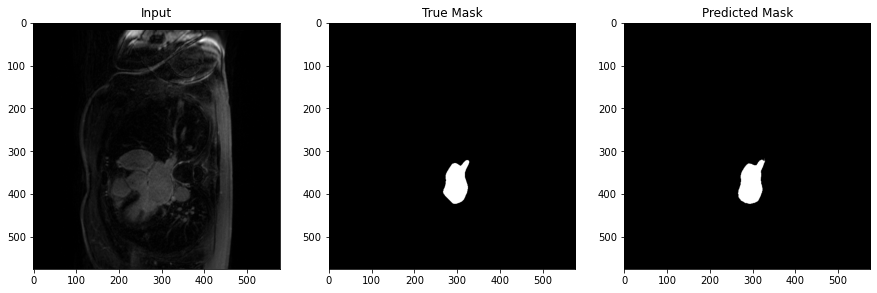

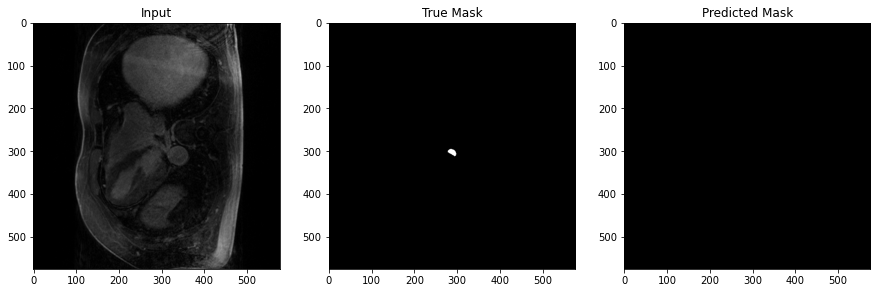

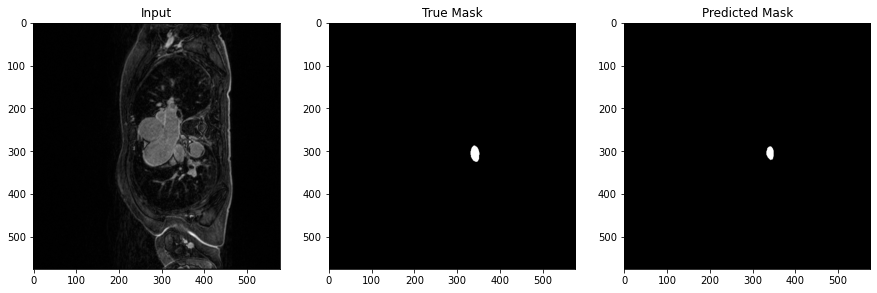

In [33]:
show_prediction(test_generator, 3)